In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
data_node1 = pd.read_csv('node1_data.csv')

In [3]:
# Drop the unnecessary columns
node1 = data_node1.drop(['timestamp', 'car_id', 'model', 'node'], axis=1)

In [4]:
# Convert 'charging' column to integer
node1['charging'] = node1['charging'].astype(int)

In [5]:
# One-hot encoding of 'location' column
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(node1[['location']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['location']))
node1.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
node1 = pd.concat([node1, encoded_df], axis=1).drop(['location'], axis=1)

In [6]:
# Split the dataset
X = node1.drop('distance_covered', axis=1)
y = node1['distance_covered']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Drop rows with NaN in y_train from both X_train and y_train
nan_indices = y_train[y_train.isnull()].index
X_train = X_train.drop(nan_indices)
y_train = y_train.drop(nan_indices)

In [9]:
# Train a Decision Tree Regressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [10]:
# Predict on test set
predictions = model.predict(X_test)

In [11]:
# Handling NaNs in the test set
y_test.fillna(y_test.mean(), inplace=True)

In [12]:
# Compute MSE, MAE, and R^2
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

In [13]:
print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"Mean Absolute Error on Test Set: {mae:.4f}")
print(f"R^2 on Test Set: {r2:.4f}")

Mean Squared Error on Test Set: 0.0000
Mean Absolute Error on Test Set: 0.0011
R^2 on Test Set: 0.9991


In [14]:
# Visualize feature importances
feature_importances = model.feature_importances_
features = X.columns

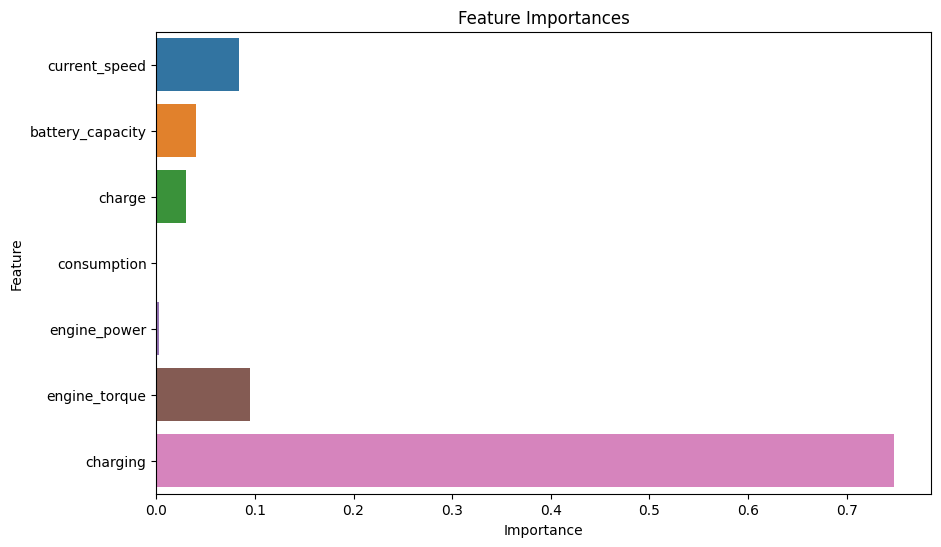

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

/tmp/ipykernel_56343/1537327910.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=False, label='Actual Values')
/tmp/ipykernel_56343/1537327910.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions, hist=False, label='Predicted Values')


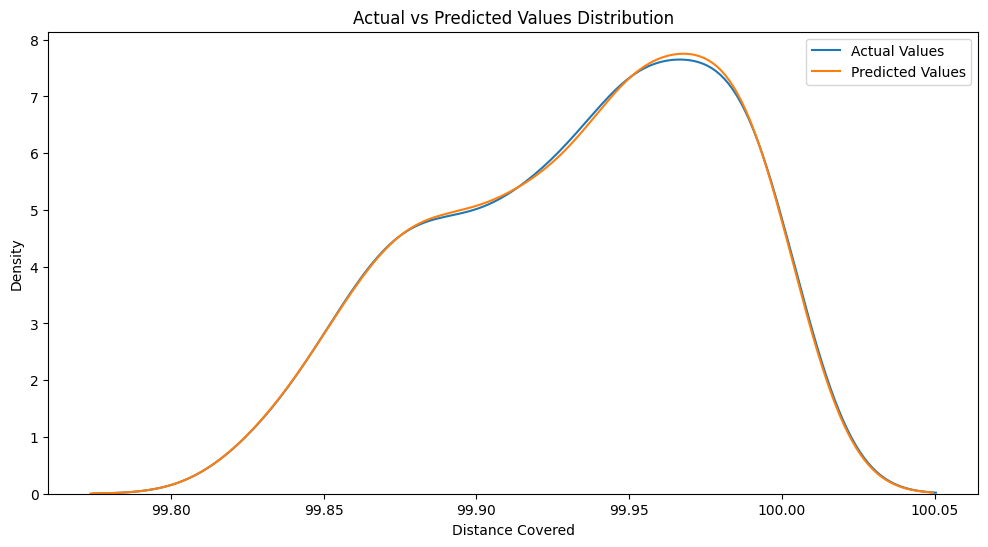

In [16]:
plt.figure(figsize=(12, 6))
sns.distplot(y_test, hist=False, label='Actual Values')
sns.distplot(predictions, hist=False, label='Predicted Values')
plt.title('Actual vs Predicted Values Distribution')
plt.xlabel('Distance Covered')
plt.legend()
plt.show()

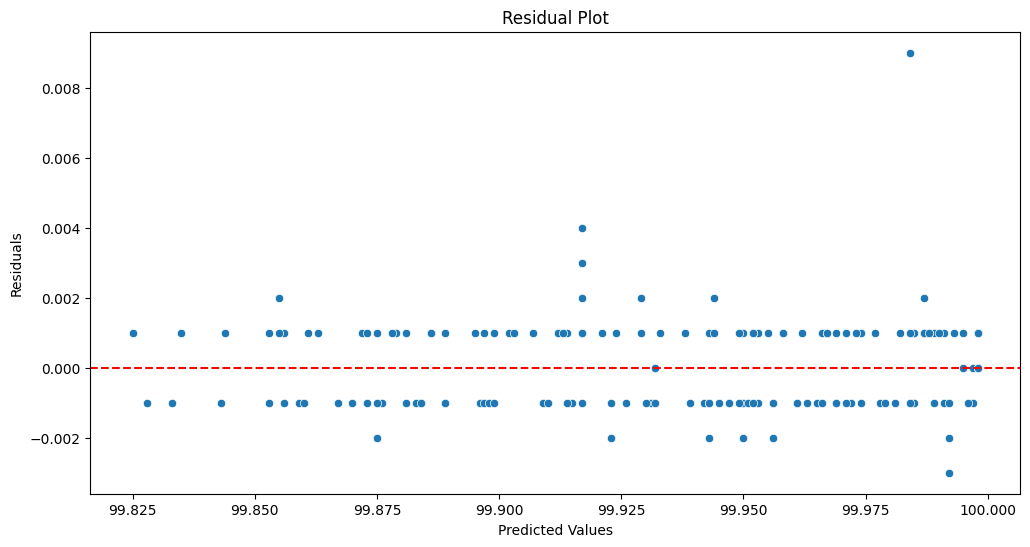

In [17]:
residuals = y_test - predictions

plt.figure(figsize=(12, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

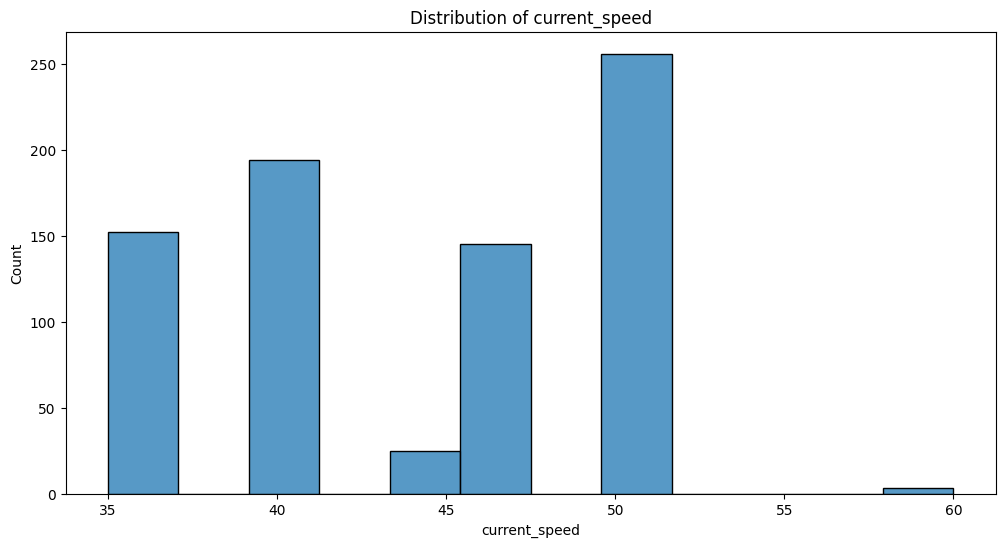

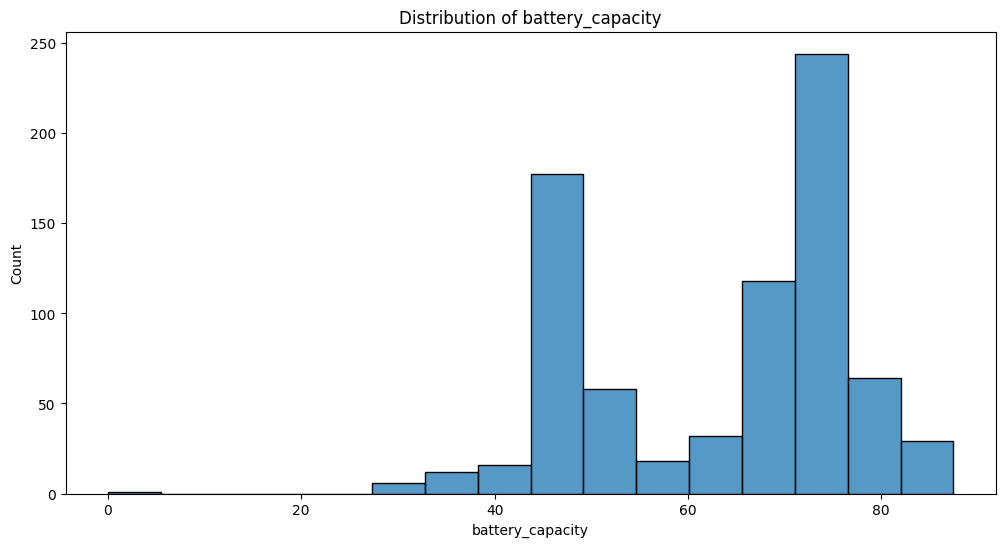

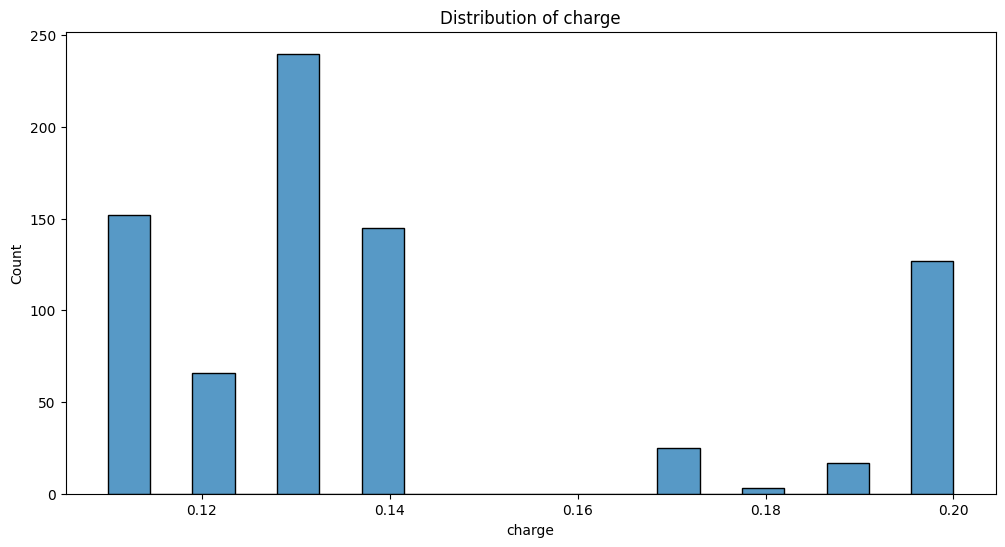

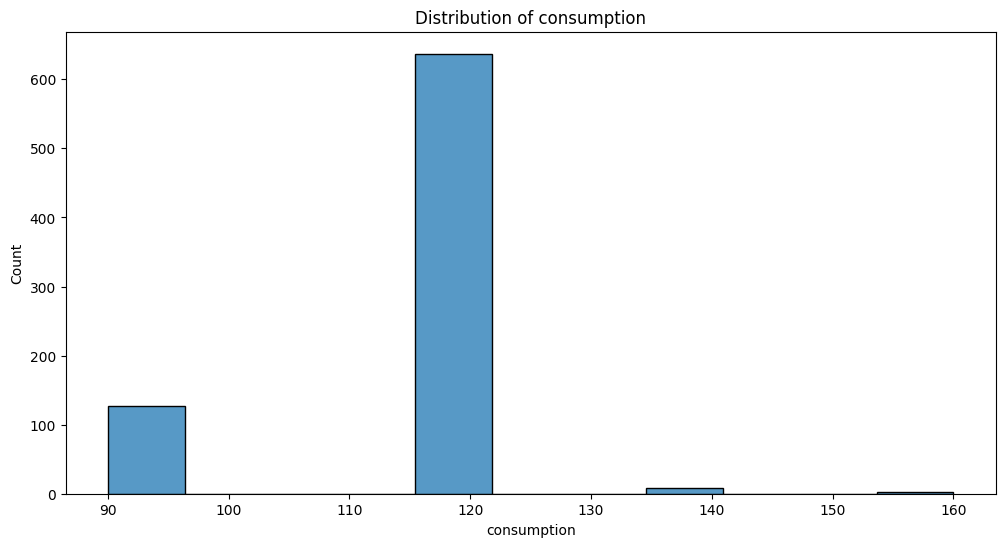

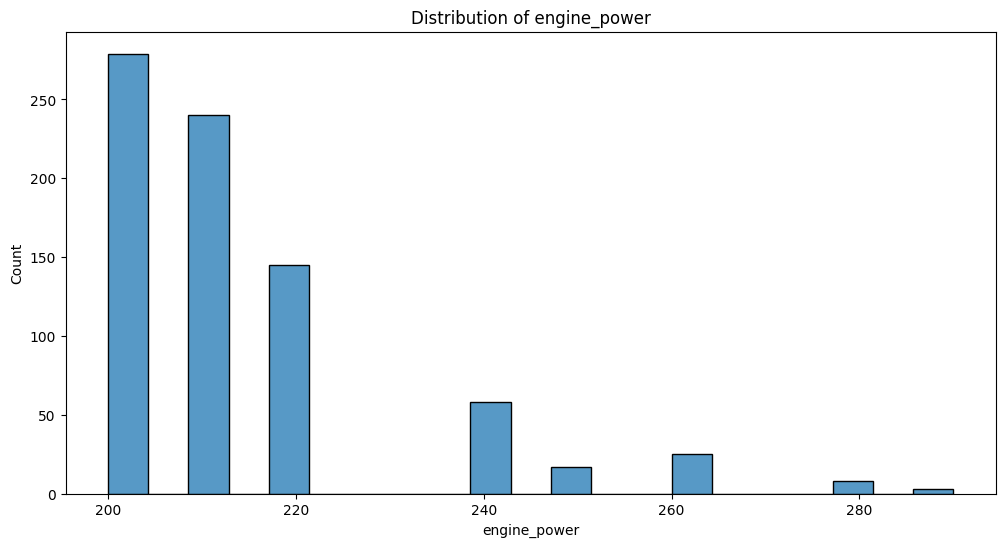

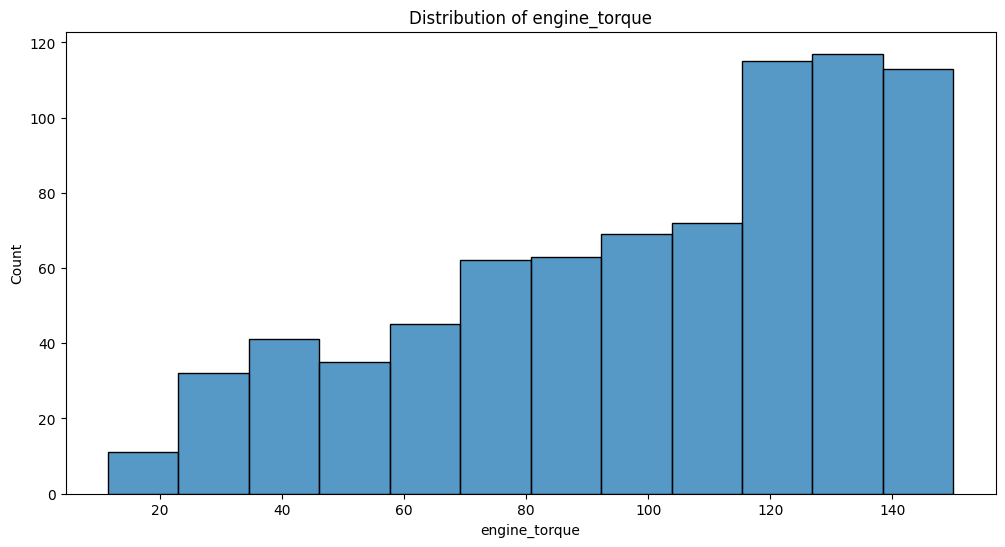

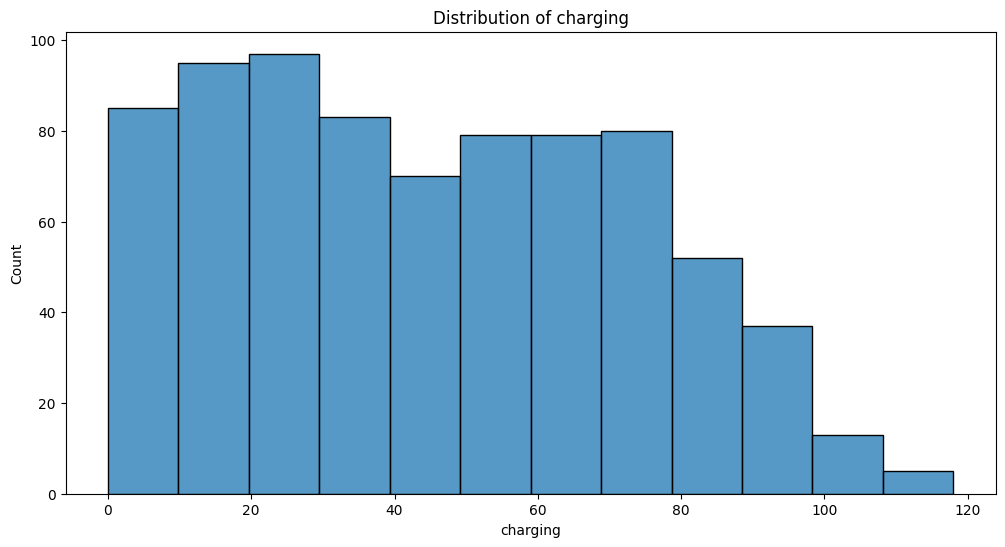

In [18]:
import seaborn as sns

for column in X.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(X[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.show()


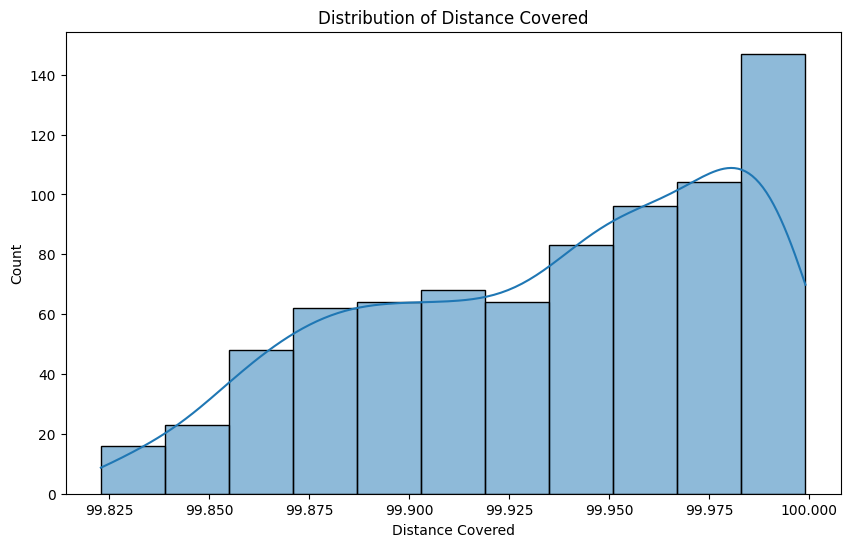

In [19]:
# 1. Distribution of the target variable
plt.figure(figsize=(10,6))
sns.histplot(node1['distance_covered'], kde=True)
plt.title('Distribution of Distance Covered')
plt.xlabel('Distance Covered')
plt.ylabel('Count')
plt.show()

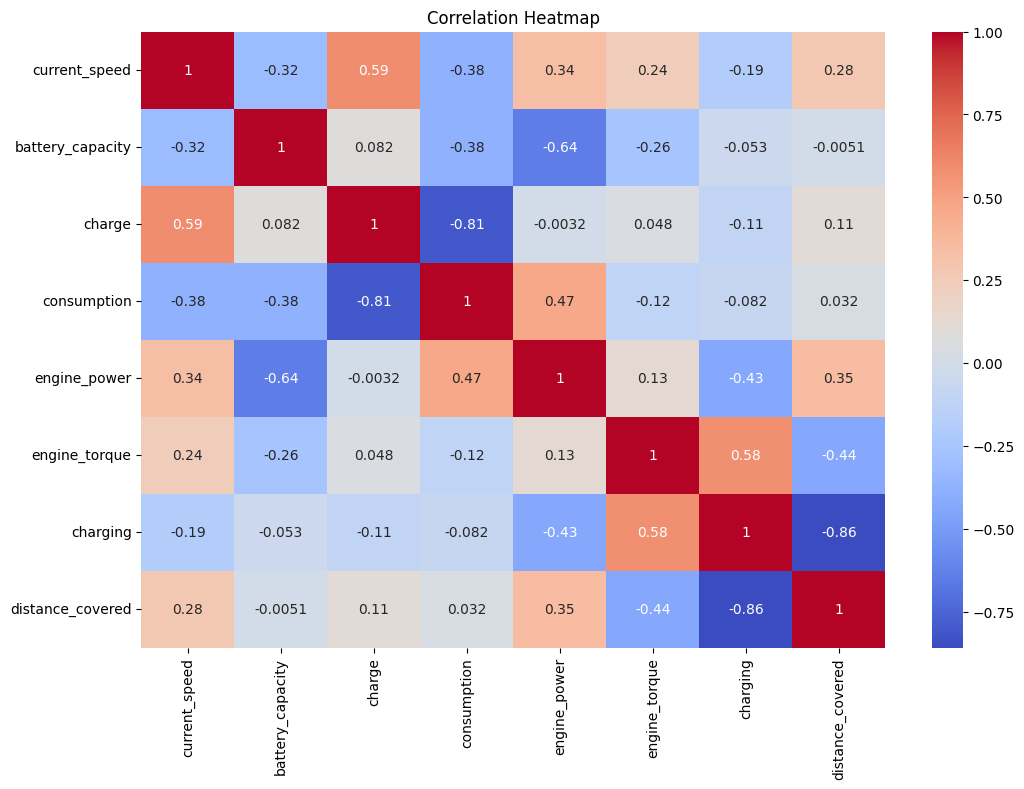

In [20]:
# 2. Correlation heatmap
correlation_matrix = node1.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

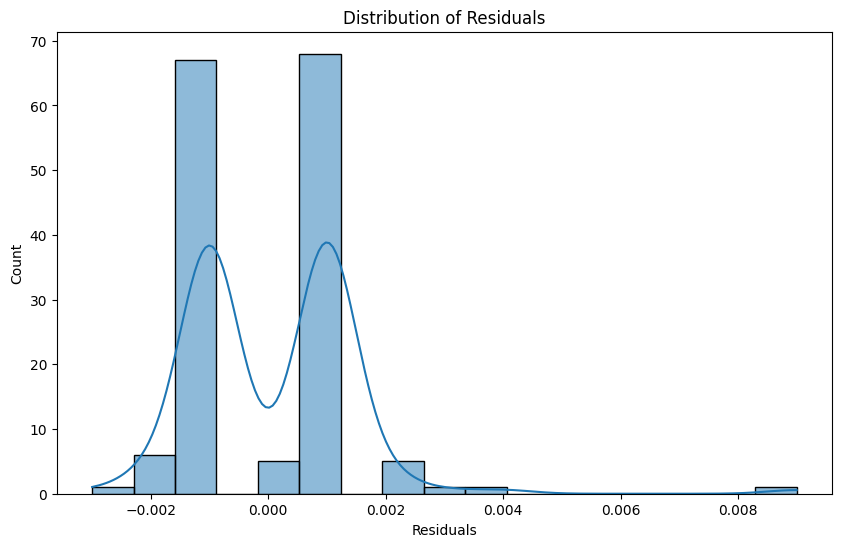

In [21]:
# 3. Residuals plot
residuals = y_test - predictions
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.show()

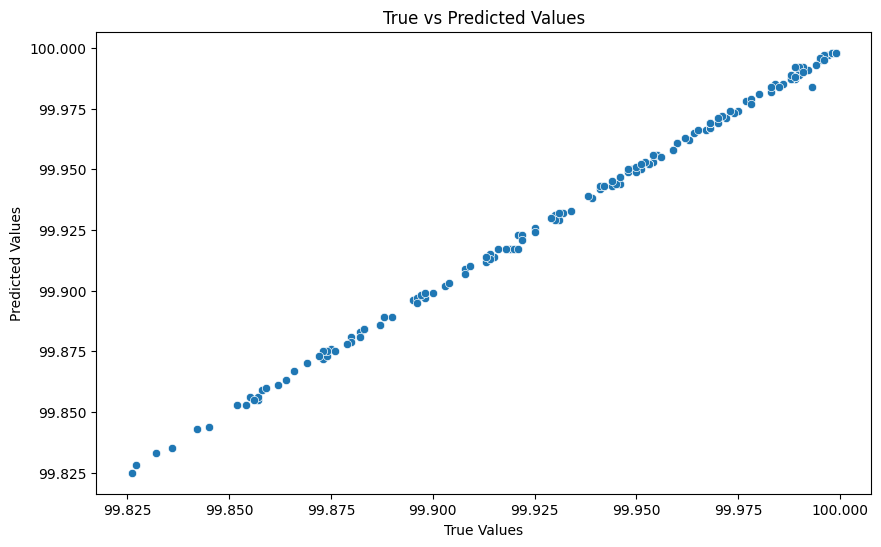

In [22]:
# 4. True vs Predicted values
import seaborn as sns
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=predictions)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

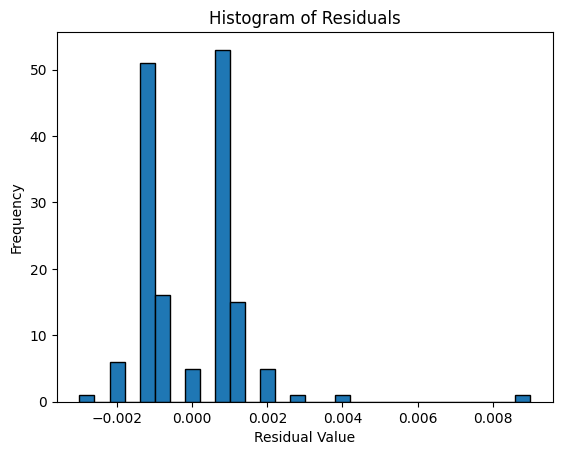

In [23]:
residuals = y_test - predictions
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

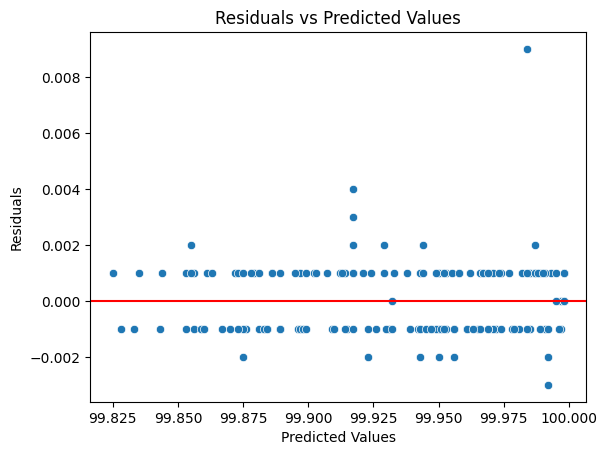

In [24]:
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

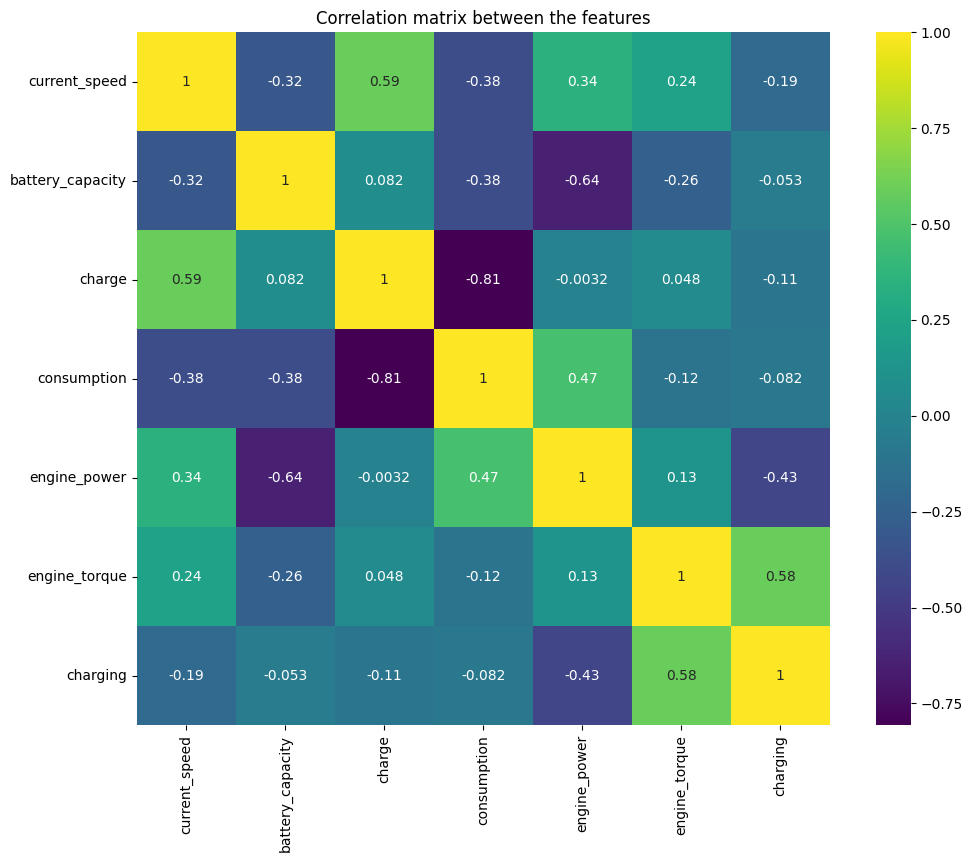

In [25]:
correlation_matrix = X.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='viridis')
plt.title('Correlation matrix between the features')
plt.show()
